In [1]:
import pandas as pd
import numpy as np
import json
import sqlite3
import pickle
from scipy.sparse import hstack, csr_matrix

#packages for preprocessing class uploaded
from sklearn.base import BaseEstimator, TransformerMixin
import nltk 
import re
from nltk import WordNetLemmatizer, pos_tag # lemmatizer using WordNet, nltk's native part of speech tagging
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize # nltk's gold standard word tokenizer
from nltk.tokenize import sent_tokenize # nltk's sentence tokenizer
from nltk.corpus import stopwords, wordnet # imports WordNet and stopwords

#packages to run NLP prediction on texts
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import folium

import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud

#imported classes for text preprocessing
from TextPreprocessors import TextPreprocessorSTEM, TextPreprocessorLEM

In [30]:
#dropdown packages
import ipywidgets as widgets
from ipywidgets import Label
from traitlets import observe
from IPython.display import display

import pandas as pd
import json
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from ipyleaflet import Map, DrawControl, Marker
from shapely.geometry import Point, Polygon

In [3]:
#import the businesses json file to populate dropdown list
with open('data/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as file:
    business_data = [json.loads(line) for line in file]
    
business_df = pd.DataFrame(business_data)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [5]:
# List to store selected coordinates
selected_coordinates = []

def handle_draw(self, action, geo_json):
    global selected_coordinates
    coordinates = geo_json['geometry']['coordinates']
    selected_coordinates = coordinates
    label.value = f"Selected Area Coordinates: {coordinates}"

# Create an interactive map
m = Map(center=(40, -75), zoom=8)

draw_control = DrawControl()
m.add_control(draw_control)

label = Label()
draw_control.on_draw(handle_draw)
display(m, label)

Map(center=[40, -75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

Label(value='')

In [6]:
selected_coordinates = [(lat, lon) for [lon, lat] in selected_coordinates[0]]

In [7]:
selected_coordinates

[(39.965731, -75.176905),
 (39.965819, -75.150809),
 (39.946169, -75.149321),
 (39.947221, -75.176333),
 (39.965731, -75.176905)]

In [8]:
polygon = Polygon(selected_coordinates[:-1])

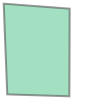

In [9]:
polygon

In [10]:
# Function to filter DataFrame based on selected area
def filter_df_by_area(df, selected_coordinates):
    filtered_rows = []
    polygon = Polygon(selected_coordinates[:-1])  #set polygon of area
    for _, row in df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        if polygon.contains(Point(lat, lon)):
            filtered_rows.append(row)
    return pd.DataFrame(filtered_rows)

In [11]:
filtered_df = filter_df_by_area(business_df, selected_coordinates)
filtered_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
130,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,1800 Spring Garden St,Philadelphia,PA,19130,39.963078,-75.168027,3.0,137,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Chinese","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:30',..."
151,WYYdQDjx-DsCanlP0DpImQ,J Sushi,243 S 10th St,Philadelphia,PA,19107,39.947033,-75.157434,4.5,72,0,"{'Ambience': '{'touristy': False, 'hipster': F...","Seafood, Restaurants, Sushi Bars, Japanese","{'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22..."
239,D9Xez9uOSM4DgSjSTywq7w,King of Jewelers,737 Samson St,Philadelphia,PA,19106,39.948902,-75.153854,4.0,5,1,None,"Shopping, Jewelry","{'Monday': '9:0-18:30', 'Tuesday': '9:0-18:30'..."
281,6bFx8j2KqPfmT0XEUS1RMg,Center City Emergency Dentist,"1429 Walnut St, Fl 6",Philadelphia,PA,19102,39.949734,-75.165436,3.5,120,1,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Orthodontists, Health & Medical, Oral Surgeons...","{'Monday': '9:0-13:0', 'Tuesday': '9:0-18:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150104,LreM6Gs1JUh3bY1hVhy7VA,Verizon FiOS,1800 Market St,Philadelphia,PA,19107,39.952783,-75.170362,1.0,192,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Television Service Providers, Professional Ser...","{'Monday': '9:0-1:0', 'Tuesday': '9:0-1:0', 'W..."
150114,2gFPQCmKKVi1aHgGTLRZvA,Green Eggs Cafe,33 S 18th St,philadelphia,PA,19103,39.952240,-75.169541,4.0,119,1,"{'BusinessAcceptsBitcoin': 'False', 'HappyHour...","Restaurants, Breakfast & Brunch, Cafes, Burgers","{'Monday': '9:0-15:0', 'Tuesday': '9:0-15:0', ..."
150126,nHsVsOms41FRXcFQM9mGXw,Pamir Grill Kabob,719 Sansom St,Philadelphia,PA,19106,39.948880,-75.153243,4.0,36,0,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Halal, Afghan, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
150235,mzTTdvQGkUHZ8ii7OnZC5w,Trader Joe's,2121 Market St,Philadelphia,PA,19103,39.954178,-75.175980,4.0,494,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Beer, Wine & Spirits, Shopping, Grocery, Flori...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."


In [12]:
autofill_input = widgets.Text(placeholder='Type here...')
display(autofill_input)

Text(value='', placeholder='Type here...')

In [13]:
saved_input = (autofill_input.value).lower()
saved_input

'korean'

In [14]:
# Convert the 'name' and 'categories' columns to lowercase
filtered_df['name_lower'] = filtered_df['name'].str.lower()
filtered_df['categories_lower'] = filtered_df['categories'].str.lower()

# Filter rows based on the saved_input in lowercase columns
result_df = filtered_df[
    (filtered_df['name_lower'].str.contains(saved_input)) |
    (filtered_df['categories_lower'].str.contains(saved_input))
]

result_df = result_df[result_df['is_open'] == 1]

# Drop the temporary lowercase columns if needed
result_df = result_df.drop(['name_lower', 'categories_lower'], axis=1)

In [15]:
result_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
28064,Em0k3l76cFj-A0tqJbkWtQ,Koreana,37 S 19th St,Philadelphia,PA,19103,39.952340,-75.171559,3.5,93,1,"{'WiFi': ''no'', 'GoodForMeal': '{'dessert': F...","Asian Fusion, Restaurants, Korean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
40075,AwvhobfqOJNBnbXQ_pB3pw,Chix & Bowls,28 S 20th St,Philadelphia,PA,19103,39.952475,-75.173532,4.0,142,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Seafood, Restaurants, Sandwiches, Korean, Asia...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
43147,mlrYh-m3Zlqp9CTeSvdOsQ,Chix & Wings,138 S 11th St,Philadelphia,PA,19107,39.948994,-75.159035,3.5,129,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'n...","Comfort Food, Korean, Chicken Shop, Restaurant...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
52633,_k1CIuPkY-uLFm8lABFG8Q,Bonchon Philadelphia,1020 Cherry St,Philadelphia,PA,19107,39.954502,-75.156990,3.5,613,1,"{'BikeParking': 'False', 'RestaurantsPriceRang...","Nightlife, Restaurants, Bars, Asian Fusion, Ch...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-1:0', ..."
56390,IsmxvaMe2i-eWnHDyC0WJQ,Rice & Mix,128 S 12th St,Philadelphia,PA,19107,39.949329,-75.160724,3.5,188,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Restaurants, Korean","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
70279,BnprLJ4Lr33--YjTmgk9Zg,Doma,1822 Callowhill St,Philadelphia,PA,19130,39.960273,-75.169239,4.0,457,1,"{'Alcohol': 'u'none'', 'RestaurantsDelivery': ...","Restaurants, Korean, Japanese, Sushi Bars","{'Monday': '0:0-0:0', 'Tuesday': '16:0-21:0', ..."
71946,qY-BUQY-SFBaSrFHowF3nA,Nine Ting,926 Race St,Philadelphia,PA,19107,39.955084,-75.155292,4.0,1213,1,"{'HasTV': 'False', 'GoodForKids': 'True', 'Bus...","Korean, Restaurants, Chinese, Barbeque, Hot Pot","{'Monday': '12:0-23:0', 'Tuesday': '12:0-23:0'..."
86662,DO_op-iq4qoaOBEhJH6EdQ,Tsaocaa & BBQ Chicken,938 Race St,Philadelphia,PA,19107,39.955344,-75.155714,3.5,160,1,"{'OutdoorSeating': 'False', 'GoodForKids': 'Tr...","Chicken Wings, Food, Bubble Tea, Korean, Resta...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
94955,XFfuR-F1_wDbcf8xo2DVPw,Dae Bak,"1016 Race St, Fl 2",Philadelphia,PA,19107,39.955270,-75.156624,4.0,214,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","Restaurants, Korean","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
107024,hGb-yA-llJ7hnw9NyzE52A,Crunchik'n,212 S 11th St,Philadelphia,PA,19107,39.948204,-75.159308,4.5,173,1,"{'DogsAllowed': 'False', 'RestaurantsReservati...","Chicken Shop, Restaurants, Korean","{'Monday': '11:30-21:0', 'Tuesday': '11:30-21:..."


In [16]:
#retrieve the reviews pertaining to the dropdown field selected and save into dataframe
bus_ids = set(result_df['business_id'])

with open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as review_file:
    review_data = [json.loads(line) for line in review_file if json.loads(line)['business_id'] in bus_ids]
    
review_df = pd.DataFrame(review_data)
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,uuUezJqax47uCIhC1-6HPQ,n-r14HfcTMDBQHxnsljqmQ,Em0k3l76cFj-A0tqJbkWtQ,3.0,0,0,0,Only eat here if you are broke. It's alright a...,2018-10-04 17:36:08
1,mhR4qpAVygQtZh8BUIHIkA,toXrN2ZSSxizh5gk17lVvA,Em0k3l76cFj-A0tqJbkWtQ,2.0,2,0,0,The food was mediocre. Kimchi was a disappoinm...,2018-06-26 21:23:39
2,nTVoXnMmkiqRXBilit-OpQ,MWuBbdypEyAhxf0p1FtodQ,Em0k3l76cFj-A0tqJbkWtQ,3.0,0,0,0,Heard great things about this place. Was so lo...,2018-06-26 21:27:58
3,lOWyv_EuyHrAVOuIELjJTg,PKi8WujD-tsxGYii8N4x2g,Em0k3l76cFj-A0tqJbkWtQ,5.0,1,0,0,We are so happy that this place also opens in ...,2018-06-09 23:55:54
4,62UXWKk-fuLh-B7TLSjX7g,Nlf8dVWTfX76teS6UARV0A,Em0k3l76cFj-A0tqJbkWtQ,4.0,2,0,1,I've been trying to find a good korean place a...,2018-06-21 16:17:37


In [17]:
review_df.shape

(4089, 9)

In [18]:
review_df['review_count'] = review_df['business_id'].map(
    lambda x: business_df.loc[business_df['business_id'] == x, 'review_count'].values[0])

review_df['business_rating_avg'] = review_df['business_id'].map(
    lambda x: business_df.loc[business_df['business_id'] == x, 'stars'].values[0])

In [19]:
#run NLP model to predict businesses that aren't open
NLP_model = joblib.load('GB_model_100k_yelp.pkl')

with open('count_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file) 

other_cols = ['stars', 'business_rating_avg', 'review_count']    
NLP_array = review_df['text']

stemmer = TextPreprocessorSTEM()
stemmed_array = stemmer.fit_transform(NLP_array)

#vectorize the text data
text_vec = vectorizer.transform(stemmed_array)
text_vec = pd.DataFrame.sparse.from_spmatrix(text_vec)
X_values = pd.concat([review_df[other_cols].reset_index(drop=True), text_vec], axis=1)
X_values = csr_matrix(X_values.values)

NLP_preds = NLP_model.predict(X_values)
review_df['prediction_open'] = NLP_preds

In [20]:
#apply the predictions to the result_df
result_preds = review_df.groupby('business_id')['prediction_open'].mean().reset_index()
result_preds = result_preds[result_preds['prediction_open'] <= 0.5]

#map values back to business_df
proxy_df = result_df[result_df['business_id'].isin(set(result_preds['business_id']))]
proxy_df['prediction_open'] = proxy_df['business_id'].map(
    lambda x: result_preds.loc[result_preds['business_id'] == x, 'prediction_open'].values[0])

<ipython-input-20-1c1f1b984fbd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_df['prediction_open'] = proxy_df['business_id'].map(


In [21]:
proxy_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,prediction_open
28064,Em0k3l76cFj-A0tqJbkWtQ,Koreana,37 S 19th St,Philadelphia,PA,19103,39.952340,-75.171559,3.5,93,1,"{'WiFi': ''no'', 'GoodForMeal': '{'dessert': F...","Asian Fusion, Restaurants, Korean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",0.094737
40075,AwvhobfqOJNBnbXQ_pB3pw,Chix & Bowls,28 S 20th St,Philadelphia,PA,19103,39.952475,-75.173532,4.0,142,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Seafood, Restaurants, Sandwiches, Korean, Asia...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",0.358621
43147,mlrYh-m3Zlqp9CTeSvdOsQ,Chix & Wings,138 S 11th St,Philadelphia,PA,19107,39.948994,-75.159035,3.5,129,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'n...","Comfort Food, Korean, Chicken Shop, Restaurant...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",0.213235
56390,IsmxvaMe2i-eWnHDyC0WJQ,Rice & Mix,128 S 12th St,Philadelphia,PA,19107,39.949329,-75.160724,3.5,188,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Restaurants, Korean","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",0.139175
86662,DO_op-iq4qoaOBEhJH6EdQ,Tsaocaa & BBQ Chicken,938 Race St,Philadelphia,PA,19107,39.955344,-75.155714,3.5,160,1,"{'OutdoorSeating': 'False', 'GoodForKids': 'Tr...","Chicken Wings, Food, Bubble Tea, Korean, Resta...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",0.191617
94955,XFfuR-F1_wDbcf8xo2DVPw,Dae Bak,"1016 Race St, Fl 2",Philadelphia,PA,19107,39.955270,-75.156624,4.0,214,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","Restaurants, Korean","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",0.235294


In [31]:
# Calculate bounding box of the polygon
min_lat = min(lat for lat, lon in selected_coordinates)
max_lat = max(lat for lat, lon in selected_coordinates)
min_lon = min(lon for lat, lon in selected_coordinates)
max_lon = max(lon for lat, lon in selected_coordinates)

# Calculate the center of the bounding box
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

# Calculate the zoom level based on the bounding box dimensions
bbox_width = max_lon - min_lon
bbox_height = max_lat - min_lat
max_bbox_dimension = max(bbox_width, bbox_height)
zoom = 14 - max_bbox_dimension  # Adjust the factor as needed

# Create an interactive map centered on the polygon with calculated zoom level
m2 = Map(center=(center_lat, center_lon), zoom=zoom)
#m2.add_layer(polygon_layer)

# Create Marker layers from the DataFrame coordinates
for index, row in proxy_df.iterrows():
    marker = Marker(location=(row['latitude'], row['longitude']))
    m2.add_layer(marker)

# Display the map
display(m2)

Map(center=[39.955994000000004, -75.16311300000001], controls=(ZoomControl(options=['position', 'zoom_in_text'…